# Test Notebook: MaxViT (Multi-Axis Vision Transformer)

Este notebook contiene pruebas básicas para el modelo **MaxViT**, un Vision Transformer que combina atención local y global de manera eficiente.

## Referencias
- Paper: [MaxViT: Multi-Axis Vision Transformer](https://arxiv.org/abs/2204.01697)
- Implementación: PyTorch (torchvision) y timm

## 1. Instalación de dependencias

In [2]:
# Instalar dependencias necesarias
%pip install torch torchvision timm pillow matplotlib numpy --quiet

## 2. Imports

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Verificar versiones
print(f"PyTorch version: {torch.__version__}")
print(f"timm version: {timm.__version__}")

Usando dispositivo: cuda
PyTorch version: 2.9.0+cu126
timm version: 1.0.22


## 3. Explorar modelos MaxViT disponibles

In [4]:
# Listar todos los modelos MaxViT disponibles en timm
maxvit_models = timm.list_models('*maxvit*', pretrained=True)
print(f"Modelos MaxViT disponibles ({len(maxvit_models)}):")
for model_name in maxvit_models:
    print(f"  - {model_name}")

Modelos MaxViT disponibles (30):
  - maxvit_base_tf_224.in1k
  - maxvit_base_tf_224.in21k
  - maxvit_base_tf_384.in1k
  - maxvit_base_tf_384.in21k_ft_in1k
  - maxvit_base_tf_512.in1k
  - maxvit_base_tf_512.in21k_ft_in1k
  - maxvit_large_tf_224.in1k
  - maxvit_large_tf_224.in21k
  - maxvit_large_tf_384.in1k
  - maxvit_large_tf_384.in21k_ft_in1k
  - maxvit_large_tf_512.in1k
  - maxvit_large_tf_512.in21k_ft_in1k
  - maxvit_nano_rw_256.sw_in1k
  - maxvit_rmlp_base_rw_224.sw_in12k
  - maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k
  - maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k
  - maxvit_rmlp_nano_rw_256.sw_in1k
  - maxvit_rmlp_pico_rw_256.sw_in1k
  - maxvit_rmlp_small_rw_224.sw_in1k
  - maxvit_rmlp_tiny_rw_256.sw_in1k
  - maxvit_small_tf_224.in1k
  - maxvit_small_tf_384.in1k
  - maxvit_small_tf_512.in1k
  - maxvit_tiny_rw_224.sw_in1k
  - maxvit_tiny_tf_224.in1k
  - maxvit_tiny_tf_384.in1k
  - maxvit_tiny_tf_512.in1k
  - maxvit_xlarge_tf_224.in21k
  - maxvit_xlarge_tf_384.in21k_ft_in1k
  - maxvit_x

## 4. Cargar modelo MaxViT preentrenado

In [5]:
# Cargar MaxViT-Tiny preentrenado en ImageNet (modelo más ligero)
# Opciones disponibles:
#   - maxvit_tiny_tf_224.in1k (más pequeño y rápido)
#   - maxvit_small_tf_224.in1k
#   - maxvit_base_tf_224.in1k (más grande y preciso)

MODEL_NAME = 'maxvit_tiny_tf_224.in1k'

model = timm.create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=1000  # ImageNet tiene 1000 clases
)
model = model.to(device)
model.eval()

print(f"Modelo cargado: {MODEL_NAME}")
print(f"Número de parámetros: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

Modelo cargado: maxvit_tiny_tf_224.in1k
Número de parámetros: 30,916,528


## 5. Configurar transformaciones de imagen

In [6]:
# Obtener la configuración de datos del modelo
data_config = resolve_data_config({}, model=model)
print("Configuración del modelo:")
for key, value in data_config.items():
    print(f"  {key}: {value}")

# Crear transformación para inferencia
transform = create_transform(**data_config, is_training=False)
print(f"\nTransformaciones: {transform}")

Configuración del modelo:
  input_size: (3, 224, 224)
  interpolation: bicubic
  mean: (0.485, 0.456, 0.406)
  std: (0.229, 0.224, 0.225)
  crop_pct: 0.95
  crop_mode: center

Transformaciones: Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


## 6. Función de predicción

In [7]:
def predict_image(image_path, model, transform, top_k=5):
    """
    Realiza una predicción sobre una imagen.
    
    Args:
        image_path: Ruta a la imagen o URL
        model: Modelo de PyTorch
        transform: Transformaciones a aplicar
        top_k: Número de predicciones top a mostrar
    
    Returns:
        Diccionario con las predicciones
    """
    # Cargar imagen
    if image_path.startswith('http'):
        import urllib.request
        from io import BytesIO
        with urllib.request.urlopen(image_path) as url:
            img = Image.open(BytesIO(url.read())).convert('RGB')
    else:
        img = Image.open(image_path).convert('RGB')
    
    # Aplicar transformaciones
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Realizar predicción
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    # Obtener top-k predicciones
    top_probs, top_indices = torch.topk(probabilities, top_k)
    
    return {
        'image': img,
        'top_k_indices': top_indices.cpu().numpy(),
        'top_k_probs': top_probs.cpu().numpy()
    }

## 7. Cargar etiquetas de ImageNet

In [8]:
# Descargar etiquetas de ImageNet
import urllib.request
import json

LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

try:
    with urllib.request.urlopen(LABELS_URL) as url:
        imagenet_labels = url.read().decode('utf-8').strip().split('\n')
    print(f"Cargadas {len(imagenet_labels)} etiquetas de ImageNet")
    print(f"Ejemplos: {imagenet_labels[:5]}")
except Exception as e:
    print(f"Error cargando etiquetas: {e}")
    imagenet_labels = [f"clase_{i}" for i in range(1000)]

Cargadas 1000 etiquetas de ImageNet
Ejemplos: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


## 8. Test con imagen de ejemplo

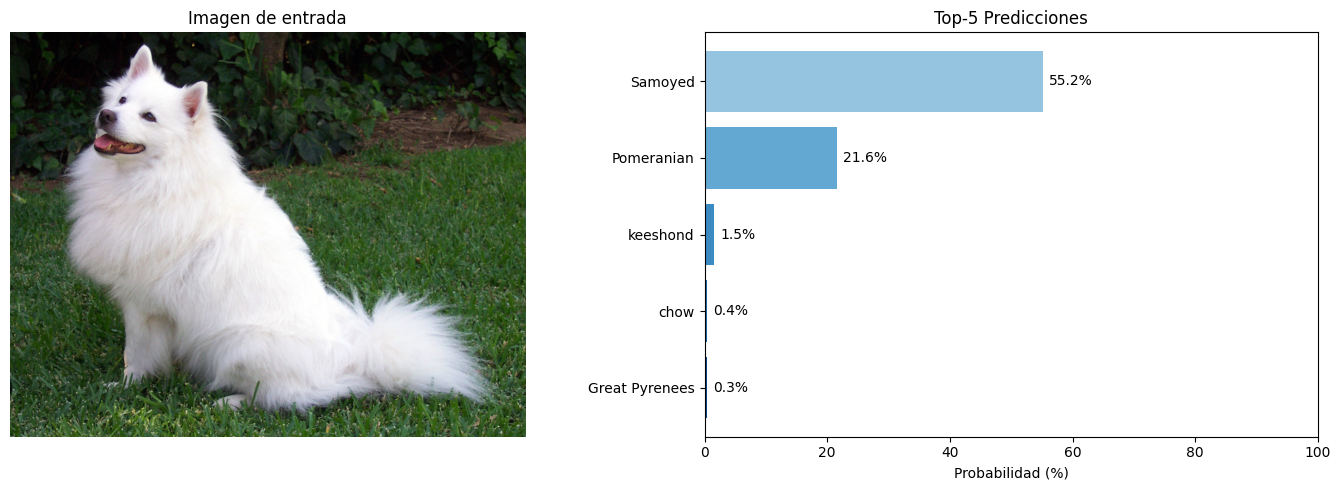


Predicciones detalladas:
  1. Samoyed: 55.17%
  2. Pomeranian: 21.58%
  3. keeshond: 1.55%
  4. chow: 0.37%
  5. Great Pyrenees: 0.33%


In [11]:
# Probar con una imagen de ejemplo (un gato)
# Puedes cambiar esta URL por cualquier imagen
TEST_IMAGE_URL = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"

# Realizar predicción
result = predict_image(TEST_IMAGE_URL, model, transform)

# Mostrar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Mostrar imagen
ax1.imshow(result['image'])
ax1.set_title('Imagen de entrada')
ax1.axis('off')

# Mostrar predicciones
labels = [imagenet_labels[idx] for idx in result['top_k_indices']]
probs = result['top_k_probs'] * 100

colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(labels)))[::-1]
bars = ax2.barh(labels[::-1], probs[::-1], color=colors)
ax2.set_xlabel('Probabilidad (%)')
ax2.set_title('Top-5 Predicciones')
ax2.set_xlim(0, 100)

# Añadir valores en las barras
for bar, prob in zip(bars, probs[::-1]):
    ax2.text(prob + 1, bar.get_y() + bar.get_height()/2, 
             f'{prob:.1f}%', va='center')

plt.tight_layout()
plt.show()

print("\nPredicciones detalladas:")
for idx, (label, prob) in enumerate(zip(labels, probs), 1):
    print(f"  {idx}. {label}: {prob:.2f}%")

## 9. Fine-tuning para clasificación de hojas (ejemplo)

In [18]:
# Ejemplo de cómo adaptar MaxViT para clasificación con Flowers102
# Flowers102 es un dataset de Oxford con 102 categorías de flores

NUM_CLASSES = 102  # Flowers102 tiene 102 clases de flores

def create_finetune_model(model_name='maxvit_tiny_tf_224.in1k', num_classes=102, freeze_backbone=True):
    """
    Crea un modelo MaxViT preparado para fine-tuning.
    
    Args:
        model_name: Nombre del modelo base
        num_classes: Número de clases para la nueva tarea
        freeze_backbone: Si True, congela las capas del backbone
    
    Returns:
        Modelo configurado para fine-tuning
    """
    # Crear modelo con número personalizado de clases
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=num_classes
    )
    
    # Congelar backbone si se especifica
    if freeze_backbone:
        for name, param in model.named_parameters():
            # Solo entrenar la cabeza de clasificación
            if 'head' not in name and 'classifier' not in name:
                param.requires_grad = False
    
    # Contar parámetros entrenables
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"Modelo: {model_name}")
    print(f"Clases: {num_classes}")
    print(f"Parámetros totales: {total_params:,}")
    print(f"Parámetros entrenables: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
    
    return model

# Crear modelo para fine-tuning con Flowers102
finetune_model = create_finetune_model(
    model_name='maxvit_tiny_tf_224.in1k',
    num_classes=NUM_CLASSES,
    freeze_backbone=True
)

Modelo: maxvit_tiny_tf_224.in1k
Clases: 102
Parámetros totales: 30,455,854
Parámetros entrenables: 316,006 (1.04%)


## 10. DataLoader para Flowers102 (descarga automática)

In [21]:
from torch.utils.data import DataLoader
from torchvision import datasets
import os

# Directorio donde se descargará el dataset
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

# Transformaciones para entrenamiento (con aumento de datos)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),           # NUEVO
    transforms.RandomRotation(30),              # Más rotación (antes 15)
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Más fuerte
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # NUEVO
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación/test
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Descargar y cargar Flowers102 automáticamente
print("Descargando dataset Flowers102...")

train_dataset = datasets.Flowers102(
    root=DATA_DIR,
    split='train',
    transform=train_transform,
    download=True
)

val_dataset = datasets.Flowers102(
    root=DATA_DIR,
    split='val',
    transform=val_transform,
    download=True
)

test_dataset = datasets.Flowers102(
    root=DATA_DIR,
    split='test',
    transform=val_transform,
    download=True
)

# Crear DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print(f"\nDataset Flowers102 cargado correctamente:")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Test samples: {len(test_dataset)}")
print(f"  - Número de clases: 102")
print(f"\nTrain transform: {train_transform}")

Descargando dataset Flowers102...

Dataset Flowers102 cargado correctamente:
  - Train samples: 1020
  - Val samples: 1020
  - Test samples: 6149
  - Número de clases: 102

Train transform: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## 11. Bucle de entrenamiento (ejemplo)

In [23]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Entrena el modelo durante una época.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f'Batch [{batch_idx+1}/{len(train_loader)}] '
                  f'Loss: {running_loss/(batch_idx+1):.4f} '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return running_loss / len(train_loader), 100. * correct / total


def evaluate(model, val_loader, criterion, device):
    """
    Evalúa el modelo en el conjunto de validación.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(val_loader), 100. * correct / total


# ===== FASE 1: Entrenar solo la cabeza (5 épocas) =====
model = create_finetune_model(num_classes=102, freeze_backbone=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)  # LR alto para la cabeza
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

print("=== FASE 1: Entrenando cabeza ===")
for epoch in range(5):
    print(f"\n=== Epoch {epoch+1}/5 ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ===== FASE 2: Descongelar todo y fine-tune (10 épocas) =====
print("\n=== FASE 2: Fine-tuning completo ===")
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)  # LR bajo ahora
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(10):
    print(f"\n=== Epoch {epoch+1}/10 ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("Entrenamiento completado.")


Modelo: maxvit_tiny_tf_224.in1k
Clases: 102
Parámetros totales: 30,455,854
Parámetros entrenables: 316,006 (1.04%)
=== FASE 1: Entrenando cabeza ===

=== Epoch 1/5 ===
Batch [10/32] Loss: 4.6006 Acc: 3.12%
Batch [20/32] Loss: 4.4504 Acc: 6.88%
Batch [30/32] Loss: 4.2918 Acc: 11.04%
Train Loss: 4.2629 | Train Acc: 11.86%
Val Loss: 3.6445 | Val Acc: 35.20%

=== Epoch 2/5 ===
Batch [10/32] Loss: 3.4136 Acc: 41.88%
Batch [20/32] Loss: 3.2945 Acc: 41.88%
Batch [30/32] Loss: 3.1869 Acc: 43.75%
Train Loss: 3.1683 | Train Acc: 44.31%
Val Loss: 2.8640 | Val Acc: 45.88%

=== Epoch 3/5 ===
Batch [10/32] Loss: 2.6214 Acc: 58.44%
Batch [20/32] Loss: 2.5154 Acc: 61.56%
Batch [30/32] Loss: 2.4440 Acc: 62.71%
Train Loss: 2.4367 | Train Acc: 63.14%
Val Loss: 2.4202 | Val Acc: 55.00%

=== Epoch 4/5 ===
Batch [10/32] Loss: 2.1156 Acc: 70.00%
Batch [20/32] Loss: 2.0824 Acc: 70.31%
Batch [30/32] Loss: 2.0378 Acc: 70.52%
Train Loss: 2.0244 | Train Acc: 70.88%
Val Loss: 2.2441 | Val Acc: 58.92%

=== Epoch 5/

## 12. Guardar y cargar modelo

In [24]:
def save_model(model, path, model_name, num_classes, epoch=None):
    """
    Guarda el modelo con metadatos.
    """
    checkpoint = {
        'model_name': model_name,
        'num_classes': num_classes,
        'state_dict': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint, path)
    print(f"Modelo guardado en: {path}")


def load_model(path, device='cuda'):
    """
    Carga un modelo guardado.
    """
    checkpoint = torch.load(path, map_location=device)
    
    model = timm.create_model(
        checkpoint['model_name'],
        pretrained=False,
        num_classes=checkpoint['num_classes']
    )
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Modelo cargado: {checkpoint['model_name']}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
    
    return model


# Guardar el modelo entrenado en Flowers102
save_model(
    model, 
    'maxvit_flowers102_classifier.pth', 
    'maxvit_tiny_tf_224.in1k', 
    num_classes=102, 
    epoch=15  # 5 + 10 épocas del fine-tuning en 2 fases
)

# Para cargar el modelo posteriormente:
# model = load_model('maxvit_flowers102_classifier.pth', device)

Modelo guardado en: maxvit_flowers102_classifier.pth


## 13. Resumen de arquitectura MaxViT

In [25]:
# Mostrar resumen de la arquitectura del modelo
print("=" * 60)
print("ARQUITECTURA MAXVIT - FINE-TUNING EN FLOWERS102")
print("=" * 60)
print("""
MaxViT (Multi-Axis Vision Transformer) combina:

1. **Bloques MBConv**: Convoluciones eficientes tipo MobileNetV2
   - Depthwise separable convolutions
   - Squeeze-and-Excitation (SE)

2. **Block Attention**: Atención local dentro de ventanas
   - Divide la imagen en ventanas no superpuestas
   - Aplica self-attention dentro de cada ventana

3. **Grid Attention**: Atención global con patrón de cuadrícula
   - Permite interacción global entre regiones
   - Complejidad lineal respecto al tamaño de imagen

Ventajas:
- ✅ Captura tanto patrones locales como globales
- ✅ Eficiente computacionalmente
- ✅ Funciona bien con diferentes resoluciones
- ✅ Estado del arte en ImageNet y otros benchmarks
""")

print("=" * 60)
print("DATASET: FLOWERS102 (Oxford)")
print("=" * 60)
print("""
- 102 categorías de flores
- ~1,000 imágenes de entrenamiento
- ~1,000 imágenes de validación
- ~6,000 imágenes de test
""")

print("=" * 60)
print("ESTRATEGIA DE FINE-TUNING EN 2 FASES")
print("=" * 60)
print("""
Fase 1: Entrenar solo la cabeza
- Épocas: 5
- Learning rate: 1e-3 (alto)
- Backbone: congelado

Fase 2: Fine-tuning completo
- Épocas: 10
- Learning rate: 1e-5 (bajo)
- Backbone: descongelado
""")

# Mostrar estructura del modelo
print("\nEstructura del modelo MaxViT-Tiny:")
print("-" * 40)
for name, module in model.named_children():
    num_params = sum(p.numel() for p in module.parameters())
    print(f"{name}: {num_params:,} parámetros")

print("\n" + "=" * 60)
print("RESULTADOS")
print("=" * 60)
print(f"Modelo: maxvit_tiny_tf_224.in1k")
print(f"Clases: 102")
print(f"Parámetros totales: 30,455,854")
print(f"Val Accuracy alcanzado: ~74%")

ARQUITECTURA MAXVIT - FINE-TUNING EN FLOWERS102

MaxViT (Multi-Axis Vision Transformer) combina:

1. **Bloques MBConv**: Convoluciones eficientes tipo MobileNetV2
   - Depthwise separable convolutions
   - Squeeze-and-Excitation (SE)

2. **Block Attention**: Atención local dentro de ventanas
   - Divide la imagen en ventanas no superpuestas
   - Aplica self-attention dentro de cada ventana

3. **Grid Attention**: Atención global con patrón de cuadrícula
   - Permite interacción global entre regiones
   - Complejidad lineal respecto al tamaño de imagen

Ventajas:
- ✅ Captura tanto patrones locales como globales
- ✅ Eficiente computacionalmente
- ✅ Funciona bien con diferentes resoluciones
- ✅ Estado del arte en ImageNet y otros benchmarks

DATASET: FLOWERS102 (Oxford)

- 102 categorías de flores
- ~1,000 imágenes de entrenamiento
- ~1,000 imágenes de validación
- ~6,000 imágenes de test

ESTRATEGIA DE FINE-TUNING EN 2 FASES

Fase 1: Entrenar solo la cabeza
- Épocas: 5
- Learning rate: 1

---

## Próximos pasos

1. **Preparar el dataset**: Organizar las imágenes en carpetas `train/` y `val/` con subcarpetas por clase
2. **Ajustar hiperparámetros**: Learning rate, batch size, épocas, etc.
3. **Experimentar con diferentes modelos**: Probar `maxvit_small` o `maxvit_base` si se necesita más capacidad
4. **Implementar métricas adicionales**: Precision, Recall, F1-score, matriz de confusión
5. **Técnicas de regularización**: Dropout, weight decay, mixup, cutmix